In [1]:
%matplotlib inline
from IPython.core.pylabtools import figsize
figsize(7,5)
# Add the application folder to the path
import sys
sys.path.insert(0,'../Peergrade/peergrade/')

import time
import math
import application.model as data_model
from collections import defaultdict
import numpy as np
from bson.objectid import ObjectId
from matplotlib import pyplot as plt
from scipy.stats.stats import pearsonr
from scipy.stats import norm


SERVER_NAME: localhost:5000


In [162]:
fig_store = "../MasterThesis/Thesis/figures/Analysis/"

# Gibbs with question dimension in Computational Tools data

In this notebook the Gibbs MCMC method is implemented and used on Computation Tools data. The method handles the data in its entirety as it will evaluate all questions in each assignments

First the data structure that the model uses is defined

In [35]:
class Grader_(object):
    def __init__(self, id):
        self.id = id
        self.handins = list()
    def set_bias(self, mean, precision):
        self.mean = mean
        self.precision = precision
    
    def get_bias(self):
        return np.random.normal(self.mean,np.sqrt(1.0/self.precision))
        
    def add_handin(self, handin):
        self.handins.append(handin)

    def grade_handins(self,questions,n_v):
        for handin in self.handins:
            for question in questions.itervalues():
                handin.add_mock_gradeing(question,self,n_v)
                
class Question_(object):
    def __init__(self,id):
        self.id = id
                
class Answers_(object):
    def __init__(self,handin,question):
        self.handin = handin
        self.question = question
        self.answers = dict()
    
    def set_mock_value(self,mean,precision):
        self.mean = mean
        self.precision = precision
        
    def set_mock_score(self,grader,score):
        self.answer[str(question)] = score

    def get_score(self):
        return np.random.normal(self.mean,np.sqrt(1.0/self.precision))

class Handin_(object):
    def __init__(self,id,owner):
        self.id = id
        self.owner = owner
        self.gradeings = dict()
        self.graders = list()
            
    def set_answers_scores(self):
        for gradeings in self.gradeings.itervalues():
            h_mu = np.random.normal(0.5,tau_std(25))
            while h_mu > 1 or h_mu < 0:
                h_mu = np.random.normal(0.5,tau_std(25))
            answer.set_mock_score(h_mu,np.random.gamma(10,1.0/ 0.1))
            
    def add_grader(self,grader):
        self.graders.append(grader)
        
    def add_answer(self,grader,question,value):
        if str(question.id) not in self.gradeings:
            self.gradeings[str(question.id)] = Answers_(self,grader)
        self.gradeings[str(question.id)].answers[str(grader.id)] = value
        
    def get_graders_answers(self):
        graders_answers = defaultdict(list)
        for q, answer in self.gradeings.iteritems():
            for g, value in answer.answers.iteritems():
                graders_answers[str(g)].append((str(q),value))
            
        return graders_answers
        
    def get_grader_answers(self,grader):
        grader_answers = list()
        for key, answer in self.gradeings.iteritems():
            grader_answers.append((key,answer.answers[grader]))
        return grader_answers
    
    def add_mock_gradeing(self,question,grader,n_v):
        if question.id not in self.gradeings:
            a = Answers_(self,grader)
            h_mu = np.random.normal(0.5,tau_std(25))
            while h_mu > 1 or h_mu < 0:
                h_mu = np.random.normal(0.5,tau_std(25))
            a.set_mock_value(h_mu,np.random.gamma(10,1.0/ 0.1))
            self.gradeings[str(question.id)] = a
        a = self.gradeings[str(question.id)]
        mock_value = np.random.normal(a.get_score()+grader.get_bias(),np.sqrt(1.0/n_v))
        a.answers[str(grader.id)] = mock_value

class Assignment_(object):
    
    def __init__(self, handins_input, graders_input, questions_input, n_gradings):
        self.graders = dict()
        self.handins = dict()
        self.questions = dict()
        self.n_gradings = n_gradings
        for handin in handins_input:
            self.handins[str(handin.id)] = handin
        for grader in graders_input:
            self.graders[str(grader.id)] = grader
        for question in questions_input:
            self.questions[str(question.id)] = question

    def add_handin(self, handin):
        self.handing[str(handin.id)] = handin
        
    def add_grader(self, grader):
        self.graders[str(grader.id)] = grader
    
    def set_questions(self, questions):
        self.questions = list(questions)
        
    def grade_mock_handins(self,n_gradings,n_v):
        self.n_gradings = n_gradings
        # Distribute handins
        for i in xrange(0,n_gradings):
            for grader in self.graders.itervalues():
                h = self.find_ungraded_handin(grader)
                h.add_grader(g)
                grader.add_handin(h)
        
        # grade handins
        for grader in self.graders.itervalues():
            grader.grade_handins(self.questions,n_v)
            
    def find_ungraded_handin(self, grader):
        
        # sort the handins by the one with the least
        sorted_l = sorted(self.handins.values(),key=lambda x: len(x.graders))
        #i = int(random.uniform(0,len(sorted_l)))
        i = 0
        handin = sorted_l[i]
        while handin in grader.handins or (handin.owner.id == grader.id):
        #while(handin.owner.name == grader.name):
            i += 1
            #i = int(random.uniform(0,len(sorted_l)))
            handin = sorted_l[i]
        return handin


Next a series of function are defined which are used for fetching the data and transforming it into the defined data structure

In [3]:
def user_name(user_id):
    user = data_model.User.objects.get(id=user_id)
    return user.name

def user_id(user_name):
    for user in data_model.User.objects(name=user_name):
        return user.id

def question_text(q_id):
    user = data_model.Question.objects.get(id=ObjectId(q_id))
    return user.text

def question_max_value(question):
    if question.question_type == "boolean":
        return 1
    elif question.question_type == "numerical":
        if question.numericalAnswers:
            max_value = max(map(int,question.numericalAnswers.keys()))
            return max_value
        else:
            return 5

def answer_value(answer):
    if answer.numerical_answer != None:
        return answer.numerical_answer / float(question_max_value(answer.question))
    if answer.boolean_answer != None:
        return answer.boolean_answer / float(question_max_value(answer.question))

def answeres_handin(report_grade):
    '''Returns a list of tuples containing the answer and the value of the question'''
    answers = data_model.Answer.objects(report_grade=report_grade)
    result = list()
    for answer in answers:
        if answer.text_answer == None:
            result.append((answer,answer_value(answer)))
    return result

In [4]:
def fetch_assignment_data(ass_obj):
    '''
    Takes an course and assignment data model object and transforms it into populated Assignment object
    Only student or all?
    '''

    print ass_obj.id
    
    ## Make dictionary to hold all the graders who have graded a handin
    graders = dict()
    
    ## Find all relevant question for the assignemnt
    questions = dict()
    for sec in ass_obj.sections:
        for question in sec.questions:
            if question.question_type != 'text':
                questions[str(question.id)] = Question_(str(question.id))
    
    ## Find all handins
    handins = dict()
    for handin_ in data_model.Handin.objects(assignment=ass_obj):
        handins[str(handin_.id)] = Handin_(str(handin_.id),str(handin_.submitter.id))    
        
    ## Find all handins graders have graded and vice versa
    n_gradings = 0
    for handin_ in data_model.Handin.objects(assignment=ass_obj):
        for grade in data_model.ReportGrade.objects(handin=handin_,state='ANSWERED'):
            
            n_gradings = n_gradings + 1
            
            # Needed if TA or Professor have graded reports as they are not initialy part of it
            if str(grade.giver.id) not in graders:
                graders[str(grade.giver.id)] = Grader_(str(grade.giver.id))
                
            handins[str(handin_.id)].add_grader(graders[str(grade.giver.id)])
            
            ## Find all answers to each question
            for answer, answer_value in answeres_handin(grade):
                if str(answer.question.id) in questions:
                    handins[str(handin_.id)].add_answer(grade.giver,answer.question,answer_value)
            
    ## update reference in graders
    for handin in handins.itervalues():
        for grader in handin.graders:
            grader.add_handin(handin)

    return Assignment_(handins.itervalues(),graders.itervalues(),questions.itervalues(),n_gradings)

The gibbs method is defined. This method takes in the defined data structure and performs MCMC. The resulting found for the different parameters are returned

In [5]:
def gibbs_model(data, samples, burn_in=0):
    
    # Counts
    N_H = len(data.handins) # Number of handins
    N_G = len(data.graders) # Number of graders
    N_Q = len(data.questions) # Number of graders
    N_g = data.n_gradings   # Number of gradings
    N_eval = N_g*N_G   # Number of evaluations in total
    
    # Hyperparameters
    ga_h = 0.5
    la_h = 1.0
    al_h = 10.0
    be_h = 0.1

    ga_g = 0.0
    la_g = 1.0
    al_g = 50.0
    be_g = 0.1
    
    al_n = 10.0
    be_n = 1.0
    
    # Prior parameters
    u_h = dict()
    t_h = dict()
    T = defaultdict(dict)
    B = defaultdict(dict)
    u_g = dict()
    t_g = dict()

    # Draw from priors
    n_v = np.random.gamma(al_n,1.0/be_n)
    for h in data.handins.iterkeys():
        t_h[h] = np.random.gamma(al_h,1.0/be_h)
        u_h[h] = np.random.normal(ga_h,np.sqrt(1.0/(la_h * t_h[h])))
        for q in data.questions.iterkeys():        
            T[h][q] = np.random.normal(u_h[h],np.sqrt(1.0/t_h[h]))
    for g in data.graders.iterkeys():
        t_g[g] = np.random.gamma(al_g,1.0/be_g)
        u_g[g] = np.random.normal(ga_g,np.sqrt(1.0/(la_g * t_g[g])))
        for q in data.questions.iterkeys():
            B[str(g)][str(q)] = np.random.normal(u_g[g],np.sqrt(1.0/t_g[g]))
            
    # Gibbs sampling #
    
    # Tracers initialising
    acc_n_v = list()
    acc_u_h = defaultdict(list)
    acc_t_h = defaultdict(list)
    acc_u_g = defaultdict(list)
    acc_t_g = defaultdict(list)
    acc_T = defaultdict(lambda: defaultdict(list))
    acc_B = defaultdict(lambda: defaultdict(list))

    tw = time.time()
    for r in range(burn_in + samples):
        print "\r%i" % (r+1) + " out of %i" % (burn_in + samples),
        # Sample T
        for h, handin in data.handins.iteritems():
            for q, answers in handin.gradeings.iteritems():
                n_gradings = len(answers.answers)
                sum_ = 0.0
                for g, val in answers.answers.iteritems():
                    sum_ = sum_ + val - B[str(g)][str(q)]
                v = n_v*n_gradings+t_h[h]
                T[h][q] = np.random.normal((u_h[h]*t_h[h]+n_v*sum_)/v,np.sqrt(1.0/v))
            
        # Sample B
        for g, grader in data.graders.iteritems():
            for q in data.questions.iterkeys():
                n_gradings = len(grader.handins)
                sum_ = 0.0
                for h in grader.handins:
                    sum_ = sum_ + h.gradeings[q].answers[g] - T[h.id][q]
                v = n_v * n_gradings + t_g[g]
                B[g][q] = np.random.normal((u_g[g]*t_g[g]+n_v*sum_)/v,np.sqrt(1.0/v))
        
        # Sample e
        sum_ = 0.0
        n_eval = 0
        for h, handin in data.handins.iteritems():
            for q, answers in handin.gradeings.iteritems():
                for g, answer_val in answers.answers.iteritems():
                    n_eval = n_eval + 1
                    sum_ = sum_ + np.square(answer_val - (T[h][q]+B[g][q]))
        n_v = np.random.gamma(al_n+0.5*n_eval,1.0 / (be_n+0.5*sum_))

        # Sample u_q and t_q
        for h in data.handins.iterkeys():
            la_ = (la_h+N_Q)
            sum_q = np.sum(T[h].values())
            mean_q = sum_q / N_Q
            sum_minus = 0.0
            for q in data.questions.iterkeys():
                sum_minus = sum_minus + np.square(T[h][q]-mean_q)
            al_ = al_h+0.5*N_Q
            be_ = be_h+0.5*(N_Q*sum_minus+(N_Q*la_h*np.square(mean_q-ga_h))/la_)
            t_h[h] = np.random.gamma(al_,1.0 / be_)
            u_h[h] = np.random.normal((la_h*ga_h+sum_q)/la_,np.sqrt(1.0/(la_*t_h[h])))

        # Sample u_g and t_g
        for g in data.graders.iterkeys():
            la_ = (la_g+N_Q)
            sum_q = np.sum(B[g].values())
            mean_q = sum_q / N_Q
            sum_minus = 0.0
            for q in data.questions.iterkeys():
                sum_minus = sum_minus + np.square(B[g][q]-mean_q)
            al_ = al_g+0.5*N_Q
            be_ = be_g+0.5*(N_Q*sum_minus+(N_Q*la_g*np.square(mean_q-ga_g))/la_)
            t_g[g] = np.random.gamma(al_,1.0 / be_)
            u_g[g] = np.random.normal((la_g*ga_g+sum_q)/la_,np.sqrt(1.0/(la_*t_g[g])))
                        
        # Collect tracings
        if r > burn_in:
            acc_n_v.append(n_v)
            for h in data.handins.iterkeys():
                acc_u_h[h].append(u_h[h])
                acc_t_h[h].append(t_h[h])
                for q in data.questions.iterkeys():
                    acc_T[h][q].append(T[h][q])
            for g in data.graders.iterkeys():
                acc_u_g[g].append(u_g[g])
                acc_t_g[g].append(t_g[g])
                for q in data.questions.iterkeys():
                    acc_B[g][q].append(B[g][q])
                    
    print
    print "Wall time: %f" % (time.time() - tw)
    
    traces = {'n_v' : acc_n_v,
              'u_h' : acc_u_h,
              't_h' : acc_t_h,
              'u_g' : acc_u_g,
              't_g' : acc_t_g,
              'T' : acc_T,
              'B' : acc_B}

    return traces

A series of methods used for plotting the data is defined

In [6]:
def truncate(string,length):
    return (string[:length] + '..') if len(string) > length else string

In [7]:
def handin_students(h_id):
    model_handin = data_model.Handin.objects.get(id=ObjectId(h_id))
    students_ = list()
    for student in model_handin.students:
        students_.append(student.name)
    return ", ".join(students_)

In [25]:
def plot_question_bias(t,result):
    for q in t.questions.iterkeys():
        scores = list()
        for id, g in t.graders.iteritems():
            scores.append((user_name(ObjectId(id)),np.mean(result['B'][id][q]),np.std(result['B'][id][q])))

        ax = plt.subplot(111)

        scores.sort(key=lambda x:x[1])
        model_1 = map(lambda x : float(x[1]),scores)
        model_e = map(lambda x : float(x[2]),scores)

        label = map(lambda x : x[0],scores)
        y = xrange(0,len(scores))
        plt.errorbar(model_1,y,xerr=model_e,fmt='or',label="Gibbs sampling",alpha=0.65)

        plt.yticks(xrange(0,len(scores)),label)
        plt.legend(loc=4)
        plt.title("Grader bias: " + question_text(q))
        plt.xlim(-0.5,0.5)
        plt.vlines(0, 0, len(scores), color="k", linestyles="--", lw=1)
        plt.ylabel("Grader")
        plt.xlabel("Bias")
        plt.show()

In [26]:
def plot_question_score(t,result):
    for q in t.questions.iterkeys():
        scores = list()
        for h, handin in t.handins.iteritems():
            scores.append((handin_students(h),np.mean(result['T'][h][q]),np.std(result['T'][h][q]),handin.answers[q].values()))

        ax = plt.subplot(111)

        scores.sort(key=lambda x:x[1])
        model_1 = map(lambda x : float(x[1]),scores)
        model_e = map(lambda x : float(x[2]),scores)
        mean = map(lambda x : x[3],scores)

        label = map(lambda x : x[0],scores)
        y = xrange(0,len(scores))
        plt.errorbar(model_1,y,xerr=model_e,fmt='or',label="Gibbs sampling",alpha=0.7)
        plt.boxplot(mean, positions=y, vert=False)

        plt.yticks(xrange(0,len(scores)),label)
        plt.legend(loc=4)
        plt.title(question_text(q))
        plt.xlim(-0.5,1.5)
        plt.ylabel("Handin")
        plt.xlabel("Score")
        plt.show()

In [27]:
def plot_handins_questions_scores(t,result):
    for h, handin in t.handins.iteritems():
        scores = list()
        for q in t.questions.iterkeys():
            scores.append((question_text(q),np.mean(result['T'][h][q]),np.std(result['T'][h][q]),handin.answers[q].values()))

        ax = plt.subplot(111)

        scores.sort(key=lambda x:x[1])
        model_1 = map(lambda x : float(x[1]),scores)
        model_e = map(lambda x : float(x[2]),scores)
        mean = map(lambda x : x[3],scores)

        label = map(lambda x : x[0],scores)
        y = xrange(0,len(scores))
        plt.errorbar(model_1,y,xerr=model_e,fmt='or',label="Gibbs sampling",alpha=0.7)
        plt.boxplot(mean, positions=y, vert=False)

        plt.yticks(xrange(0,len(scores)),label)
        plt.legend(loc=4)
        plt.title(handin_students(h))
        plt.xlim(-0.5,1.5)
        plt.ylabel("Handin")
        plt.xlabel("Score")
        plt.show()

In [147]:
def plot_bias(t,result,nth=1):
    scores = list()
    for id, g in t.graders.iteritems():
        text = truncate(user_name(ObjectId(id)),45)
        text = text + ": %i" % len(t.graders[id].handins)
        q_bias = list()
        for q in t.questions.iterkeys():
            q_bias.append(result['B'][id][q])
        scores.append((text,np.mean(result['u_g'][id]),np.sqrt(1.0 / np.mean(result['t_g'][id])),q_bias))
    scores = scores[::nth]
    ax = plt.subplot(111)

    scores.sort(key=lambda x:x[1])
    model_1 = map(lambda x : float(x[1]),scores)
    xerr = map(lambda x : float(x[2]),scores)
    bias_q = map(lambda x : x[3],scores)
    
    label = map(lambda x : x[0],scores)
    y = xrange(0,len(scores))
    plt.errorbar(model_1,y,xerr=xerr,fmt='o',color="#467821",label="Latent Bias")
    plt.boxplot(bias_q, positions=y, vert=False)

    plt.yticks(xrange(0,len(scores)),label)
    leg = plt.legend(numpoints=1,loc=4)
    leg.get_frame().set_alpha(0.4)
    plt.title("Bias of the graders")
    plt.vlines(0, 0, len(scores), color="k", linestyles="--", lw=1)
    plt.ylabel("Grader : [Graded handins]")
    plt.xlabel("Bias")
    plt.show()

In [29]:
def plot_bias_dist(t,result):
    scores = list()
    for id in t.graders.iterkeys():
        q_text = truncate(user_name(ObjectId(id)),45)
        scores.append((q_text,np.mean(result['u_g'][id]),np.sqrt(1.0 / np.mean(result['t_g'][id]))))
        
    scores.sort(key=lambda x:x[1])
    
    n = len(scores)
    x = np.linspace(-0.5,0.5,1000)    
    
    for k, (label,m,s) in enumerate(scores):
        ax = plt.subplot(math.ceil(n / 2.0), 2, k + 1)
        
        plt.xlabel("Probability of the bias")
        plt.title(label)
        plt.setp(ax.get_yticklabels(), visible=False)

        y = norm.pdf(x, loc=m, scale=s)
        plt.plot(x,y,label = "Mean: %.2f,\nStd: %.2f" % (m,s))
        plt.fill_between(x, 0, y, color="#348ABD", alpha=0.4)
        plt.vlines(m, 0, max(y), color="k", linestyles="--", lw=1)
        
        leg = plt.legend(loc=2)
        leg.get_frame().set_alpha(0.4)
        plt.autoscale(tight=True)

    plt.suptitle("Distribution of grader bias",
             y=1.02,
             fontsize=14)

    plt.tight_layout()
    plt.show()

In [151]:
def plot_handins(t,result,nth=1):
    scores = list()
    for id, handin in t.handins.iteritems():
        gradings = list()
        for x  in handin.get_graders_answers().values():
            inter = list()
            for (q,val) in x:
                inter.append(val)
            gradings.append(np.mean(inter))
        l = truncate(handin_students(id),45)
        scores.append((l,np.mean(result['u_h'][id]),np.sqrt(1.0 / np.mean(result['t_h'][id])),gradings))

    ax = plt.subplot(111)

    scores.sort(key=lambda x:x[1])
    scores = scores[::nth]
    model_1 = map(lambda x : float(x[1]),scores)
    xerr = map(lambda x : x[2],scores)
    mean = map(lambda x : x[3],scores)
    
    label = map(lambda x : x[0],scores)
    y = xrange(0,len(scores))
#    plt.plot(model_1,y,'o',color="#348ABD",label="Latent Handin Score",alpha=0.65)
    plt.errorbar(model_1,y,xerr=xerr,fmt='o',color="#A60628",label="Latent Handin Score",alpha=0.65)
#    plt.boxplot(mean, positions=y, vert=False)
    
    plt.yticks(xrange(0,len(scores)),label)
    leg = plt.legend(numpoints=1,loc=4)
    leg.get_frame().set_alpha(0.4)
    plt.title("True score of handins")
    plt.vlines(0, 0, len(scores), color="k", linestyles="--", lw=1)
    plt.vlines(1, 0, len(scores), color="k", linestyles="--", lw=1)
    plt.ylabel("Question")
    plt.xlabel("Score")
#    plt.xlim(0,1)
    plt.margins(0.02)
    plt.tight_layout()
    plt.show()

In [155]:
def plot_handins_dist(t,result):
    scores = list()
    for id in t.handins.iterkeys():
        l = truncate(handin_students(id),45)
        scores.append((l,np.mean(result['u_h'][id]),np.sqrt(1.0 / np.mean(result['t_h'][id]))))
    scores.sort(key=lambda x:x[1])
    
    n = len(scores)
    x = np.linspace(0,1,1000)    
    
    for k, (label,m,s) in enumerate(scores):
        ax = plt.subplot(math.ceil(n / 2.0), 2, k + 1)
        
        plt.xlabel("Probability of the question score")
        plt.title(label)
        plt.setp(ax.get_yticklabels(), visible=False)

        y = norm.pdf(x, loc=m, scale=s)
        plt.plot(x,y,label = "Mean: %.2f,\nStd: %.2f" % (m,s))
        plt.fill_between(x, 0, y, color="#348ABD", alpha=0.4)
        plt.vlines(m, 0, max(y), color="k", linestyles="--", lw=1)
        
        leg = plt.legend(loc=2)
        leg.get_frame().set_alpha(0.4)
        plt.autoscale(tight=True)

    plt.suptitle("Distribution of question scores",
             y=1.02,
             fontsize=14)

    plt.tight_layout()
    plt.show()

In [154]:
from collections import OrderedDict

In [167]:
def plot_collected_handin_score(t,result,nth=1):
    scores = list()

    for h, handin in t.handins.iteritems():
        g_c = list()
        h_list = list()
        for q in t.questions.iterkeys():
            l = list()
            for answers in handin.gradeings[q].answers.itervalues():
                l.append(answers)
            h_list.append(np.mean(result['T'][h][q]))
            g_c.append(np.mean(l))
        obs_v = g_c
        model_v = h_list
        scores.append((h,model_v,obs_v,np.mean(result['u_h'][h])))
    
    ax = plt.subplot(111)

    scores.sort(key=lambda x:x[3])
    scores = scores[::nth]
    
    model = map(lambda x : x[1],scores)
    obs = map(lambda x : x[2],scores)
    obs_m = map(lambda x : np.mean(x[2]),scores)
    found = map(lambda x : x[3],scores)

    y = range(0,len(scores)*2,2)
    for i in range(len(scores)):
        y_ = y[i]
        
        plt.hlines(y_-1, -0.2, 1.2, color="k", linestyles="-", lw=1,alpha=0.5)
        
        if i == 0:
            plt.plot(obs_m[i],y_+0.6,'o',color='#348ABD',label="Observed Handin Score")
            plt.plot(obs[i],[y_+0.2]*len(obs[i]),'|',color="#348ABD", label="Observed Questions Scores")
            plt.plot(found[i],y_-0.2,'o',color="#A60628",label="Found Handin Score")
            plt.plot(model[i],[y_-0.6]*len(model[i]),'|',color="#A60628", label="Found Question Scores")
        plt.plot(obs_m[i],y_+0.6,'o',color="#348ABD")
        plt.plot(obs[i],[y_+0.2]*len(obs[i]),'|',color="#348ABD")
        plt.plot(found[i],y_-0.2,'o',color="#A60628")
        plt.plot(model[i],[y_-0.6]*len(model[i]),'|',color="#A60628")
        

    label = map(lambda x : truncate(handin_students(x[0]),45),scores)
    
    plt.yticks(y,label)
    leg = plt.legend(numpoints=1,loc=2)
    leg.get_frame().set_alpha(0.4)
    plt.xlim(-0.2,1.2)
    plt.autoscale(tight=True)
    plt.title("Score")
    plt.ylabel("Owners of the handins")
    plt.xlabel("Model score vs Question score vs Observed Question score")
    plt.margins(0.05)
    plt.tight_layout()
    plt.show()

In [17]:
def plot_collected_question_score(t,result):
    scores = list()
    
    for q in t.questions.iterkeys():
        g_c = defaultdict(list)
        for h, handin in t.handins.iteritems():
            for g, val in handin.answers[q].iteritems():
                g_c[q].append(val)
        mean_v = g_c.values()
        h_c = defaultdict(list)
        for h, handin in result['T'].iteritems():
            h_c[q].append(np.mean(handin[q]))
        model_v = h_c.values()
        scores.append((question_text(q),model_v,mean_v))

    scores.sort(key=lambda x:np.mean(x[2]))

    model_1 = map(lambda x : x[1],scores)
    mean = map(lambda x : x[2],scores)

    label = map(lambda x : x[0],scores)
    y = xrange(0,len(scores))

    
    ax = plt.subplot(111)

    plt.boxplot(mean, positions=y, vert=False)

    box = ax.get_position()
    ax.set_position([box.x0, box.y0,
                     box.width+0.45, box.height*4])
    plt.yticks(xrange(0,len(scores)),label)
    plt.legend(loc=4)
    plt.title("Observed score of questions")
    plt.xlim(-0.2,1.2)
    plt.ylabel("Question")
    plt.xlabel("Score")

    plt.show()
    
    ax = plt.subplot(111)

    plt.boxplot(model_1, positions=y, vert=False)

    box = ax.get_position()
    ax.set_position([box.x0, box.y0,
                     box.width+0.45, box.height*4])
    plt.yticks(xrange(0,len(scores)),label)
    plt.legend(loc=4)
    plt.xlim(-0.2,1.2)
    plt.title("MCMC score of questions")
    plt.ylabel("Question")
    plt.xlabel("Score")
    plt.show()

In [18]:
def get_sorted_result(t,result):
    s = list()
    for name, g in t.graders.iteritems():
        
        s.append((user_name(ObjectId(name)),np.mean(result['u_g'][name])))
    s.sort(key=lambda x:x[1])
    return s

With these methods defined the data data can be fetched, handled by MCMC and visualized

The gibbs models is used on each assignment in the Course "Computational Tools for Big data" and the data is analyzed

## Mock data

Create data

In [ ]:
def tau_std(value):
    return np.sqrt(1.0 / value)

In [ ]:
handins_data = list()
graders_data = list()
questions_data = list()
answers_data = list()

graders = 60
questions = 20
gradings = 5

for i in xrange(questions):
    q = Question_('question_%i' % i)
    questions_data.append(q)

for i in xrange(graders):
    g = Grader_('grader_%i' % i)
    g.set_bias(np.random.normal(0,tau_std(100)),np.random.gamma(50,1.0 / 0.1))
    h = Handin_('handin_%i' % i, g)
    h.set_answers_scores()
    graders_data.append(g)
    handins_data.append(h)
    
mock_data = Assignment_(handins_data,graders_data,questions_data,graders*gradings)
mock_data.grade_mock_handins(gradings,np.random.gamma(50,1.0 / 0.1))

In [ ]:
mock_result = gibbs_model(mock_data,6000)

graders:time
10:8.115373
20:15.852409
40:32.015021
100:78.589409

In [ ]:
def find_bias_(assignment,mcmc,f):
    bias = list()
    for g in assignment.graders.keys():
        value = 0
        if f == 'var':
            value = np.mean(mcmc['t_g'][g][:])
        elif f == 'mean':
            value = np.mean(mcmc['u_g'][g][:])
        bias.append((value,g))
    return bias

In [ ]:
def find_T_(assignment,mcmc,f):
    T = list()
    for h in assignment.handins.keys():
        value = 0
        if f == 'var':
            value = np.mean(mcmc['t_h'][h][:])
        elif f == 'mean':
            value = np.mean(mcmc['u_h'][h][:])
        T.append((value,h))
    return T

In [ ]:
def compare_to_generated(assignment_data,mcmc_handins,find,func='mean',ax=None):
    bias_abs_1 = find(assignment_data, mcmc_handins, func)
    # Generate dict of the found values in each run for each grader
    compared = defaultdict(list)
    collected = bias_abs_1[:]
    
    for (value, _id) in collected:
        compared[_id] = value
        
    sorted_list = list()
    if "bias" in find.func_name:
        for _id, g in assignment_data.graders.iteritems():
            if func == "mean":
                sorted_list.append((_id,g.mean))
            else:
                sorted_list.append((_id,g.precision))
    else:
        for _id, h in assignment_data.handins.iteritems():
            c_s = list()
            for answers in h.gradeings.itervalues():
                if func == "mean":                        
                    c_s.append(answers.mean)
                else:
                    c_s.append(answers.precision)
            sorted_list.append((_id,np.mean(c_s)))
            
    sorted_list.sort(key=lambda x: x[1])
    
    labels = list()
    true_values = list()
    score_values = list()
    mean_score_values = list()
    tau_score_values = list()
    MS_val = list()
    y = xrange(0,len(sorted_list))
    for (_id, value) in sorted_list:
        if "bias" not in find.func_name:
            if func == "mean":
                c = list()
                for q, answers in mock_data.handins[_id].gradeings.items():
                    c.append(answers.answers.values())
                mean_score = np.mean(c)
                mean_score_values.append(mean_score)
        
        MS_val.append(compared[_id])
        score_values.append(compared[_id])
        true_values.append(value)
        labels.append(_id)
    
    MSE_T = 0.0
    MSE_M = sum(map(lambda x : (float(x[1]) - float(x[0])) ** 2,zip(true_values,MS_val))) / len(true_values)
    print MSE_M
    if "bias" not in find.func_name and func == "mean":
        MSE_T = sum(map(lambda x : (float(x[1]) - float(x[0])) ** 2,zip(true_values,mean_score_values))) / len(true_values)
        print MSE_T
    box_text = ""
    if func == "mean" and ax:
        if "bias" not in find.func_name:
            box_text = 'MSE model: %f\nMSE graded: %f' % (MSE_M,MSE_T)
        else:
            box_text = 'MSE model: %f' % MSE_M
        props = dict(boxstyle='round', facecolor='white', alpha=0.5)
        ax.text(0.05, 0.95, box_text, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    y_ = map(lambda x: x,y)
    if "bias" in find.func_name:
        plt.plot(score_values,y_,'o',color="#467821",label="Expected value of\nposterior",alpha=0.6,linewidth=0)
        plt.plot(true_values,y,'.',color="#A60628",label="True value",alpha=0.6,linewidth=0)
    else:
        if func == "mean":
            plt.plot(mean_score_values,y,'o',color="#A60628",label="Mean value of\nobserved scores",alpha=0.6)
        plt.plot(score_values,y,'o',color='#348ABD',label="Expected value of\nposterior",alpha=0.6,linewidth=0)
        plt.plot(true_values,y,'.',label="True value",alpha=0.6,linewidth=0)
    plt.yticks(xrange(0,len(sorted_list)),labels)
    leg = plt.legend(loc=4,numpoints=1)
    leg.get_frame().set_alpha(0.4)
    if "bias" in find.func_name:
        if func == "mean":
            plt.title(r'True $\mu_g$ compared to infered $\mu_g$')
        else:
            plt.title(r'True $\tau_g$ compared to infered $\tau_g$')
        plt.ylabel("Graders")
    else:
        if func == "mean":
            plt.title(r'True $\mu_h$ compared to infered $\mu_h$')
        else:
            plt.title(r'True $\tau_h$ compared to infered $\tau_h$')
        plt.ylabel("Handins")

In [ ]:
figsize(12,5)
ax = plt.subplot(1,2,1)
compare_to_generated(mock_data,mock_result,find_T_,'mean',ax)
plt.margins(0.02)
plt.subplot(1,2,2)
compare_to_generated(mock_data,mock_result,find_T_,'var')
plt.margins(0.02)
plt.tight_layout()

In [ ]:
figsize(12,5)
ax = plt.subplot(1,2,1)
compare_to_generated(mock_data,mock_result,find_bias_,'mean',ax)
plt.margins(0.02)
plt.subplot(1,2,2)
compare_to_generated(mock_data,mock_result,find_bias_,'var')
plt.margins(0.02)
plt.tight_layout()

In [ ]:
def find_T(assignment,mcmc,f,handin):
    T = list()
    for q in assignment.questions.keys():
        value = 0
        if f == 'var':
            value = np.mean(mcmc['T'][handin][q])
        elif f == 'mean':
            value = np.mean(mcmc['T'][handin][q])
        T.append((value,q))
    return T

In [ ]:
def compare_to_generated_q(assignment_data,mcmc_handins,find,handin,func='mean',ax=None):
    bias_abs_1 = find(assignment_data, mcmc_handins, func,handin)
    # Generate dict of the found values in each run for each grader
    compared = defaultdict(list)
    collected = bias_abs_1[:]
    
    for (value, _id) in collected:
        compared[_id] = value
        
    sorted_list = list()
    if "bias" in find.func_name:
        for _id, g in assignment_data.graders.iteritems():
            if func == "mean":
                sorted_list.append((_id,g.mean))
            else:
                sorted_list.append((_id,g.precision))
    else:
        h = assignment_data.handins[handin]
        c_s = list()
        for q, answers in h.gradeings.iteritems():
            if func == "mean":                        
                sorted_list.append((q,answers.mean))
            else:
                sorted_list.append((q,answers.precision))
            
    sorted_list.sort(key=lambda x: x[1])
    
    labels = list()
    true_values = list()
    score_values = list()
    mean_score_values = list()
    tau_score_values = list()
    MS_val = list()
    y = xrange(0,len(sorted_list))
    for (_id, value) in sorted_list:
        if "bias" not in find.func_name:
            if func == "mean":
                h = mock_data.handins[handin]
                mean_score = np.mean(h.gradeings[_id].answers.values())
                mean_score_values.append(mean_score)
        
        MS_val.append(compared[_id])
        score_values.append(compared[_id])
        true_values.append(value)
        labels.append(_id)
    
    MSE_T = 0.0
    MSE_M = sum(map(lambda x : (float(x[1]) - float(x[0])) ** 2,zip(true_values,MS_val))) / len(true_values)
#    print MSE_M
    if "bias" not in find.func_name and func == "mean":
        MSE_T = sum(map(lambda x : (float(x[1]) - float(x[0])) ** 2,zip(true_values,mean_score_values))) / len(true_values)
#        print MSE_T
    box_text = ""
    if func == "mean" and ax:
        if "bias" not in find.func_name:
            box_text = 'MSE model: %f\nMSE graded: %f' % (MSE_M,MSE_T)
        else:
            box_text = 'MSE model: %f' % MSE_M
        props = dict(boxstyle='round', facecolor='white', alpha=0.5)
        ax.text(0.05, 0.95, box_text, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    y_ = map(lambda x: x,y)
    if "bias" in find.func_name:
        plt.plot(score_values,y_,'o',color="#467821",label="Expected value of\nposterior",alpha=0.6,linewidth=0)
        plt.plot(true_values,y,'.',color="#A60628",label="True bias",alpha=0.6,linewidth=0)
    else:
        if func == "mean":
            plt.plot(mean_score_values,y,'o',color="#A60628",label="Mean value of\nobserved scores",alpha=0.6)
        plt.plot(score_values,y,'o',color='#348ABD',label="Expected value of\nposterior",alpha=0.6,linewidth=0)
        plt.plot(true_values,y,'.',label="True value",alpha=0.6,linewidth=0)
    plt.yticks(xrange(0,len(sorted_list)),labels)
    leg = plt.legend(loc=4,numpoints=1)
    leg.get_frame().set_alpha(0.4)
    if "bias" in find.func_name:
        if func == "mean":
            plt.title(r'True $\mu_g$ compared to infered $\mu_g$')
        else:
            plt.title(r'True $\tau_g$ compared to infered $\tau_g$')
        plt.ylabel("Graders")
    else:
        if func == "mean":
            plt.title(r'True $\mu_hq$ compared to infered $\mu_hq$')
        else:
            plt.title(r'True $\tau_h$ compared to infered $\tau_h$')
        plt.ylabel("Questions")

In [ ]:
figsize(12,5)
ax = plt.subplot(1,2,1)
compare_to_generated_q(mock_data,mock_result,find_T,'handin_0','mean',ax)
plt.tight_layout()
plt.margins(0.05)
plt.show()

## Assignment 1

In [37]:
a1 = data_model.Assignment.objects.get(title="UNIX, Python and Fast Data")

a1_data = fetch_assignment_data(a1)

55f277cff3bd61000a2112d4


In [20]:
a1_result = gibbs_model(a1_data,5000,burn_in=1000)

6000 out of 6000
Wall time: 860.635727


Unexplained iid residue defined by a variance

In [98]:
from matplotlib.backends.backend_pdf import PdfPages

Expected Value: 0.039521
StD: 0.385357


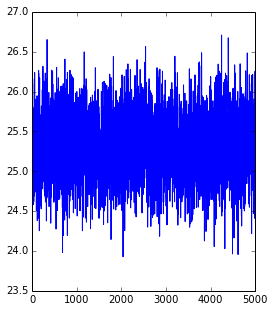

In [102]:
with PdfPages('test_pdf.pdf') as pdf:
    fig = plt.figure(figsize=(7, 5))
    print "Expected Value: %f" % (1.0 / np.mean(a1_result['n_v']))
    print "StD: %f" % np.std(a1_result['n_v'])
    plt.plot(a1_result['n_v'])
    plt.show()
    pdf.savefig(fig)

Bias of the graders $u_g$

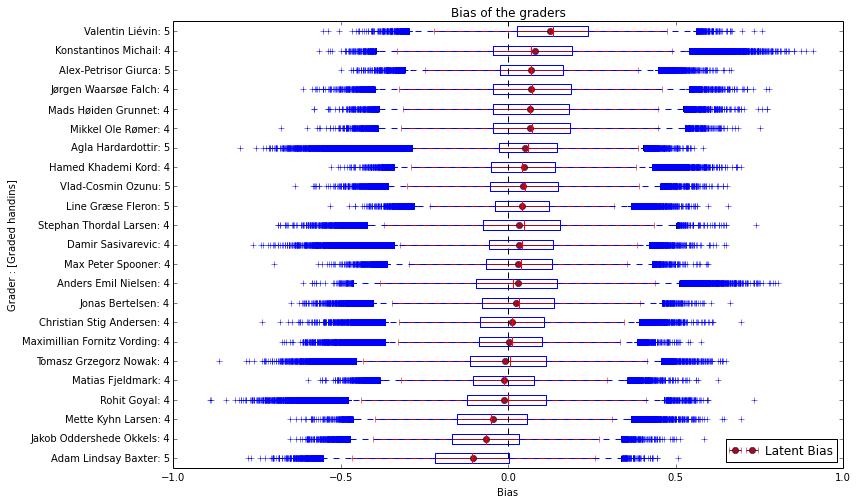

In [145]:
#with PdfPages('CT_Ass1_Bias.pdf') as pdf:
fig = plt.figure(figsize=(12, 8))
plot_bias(a1_data,a1_result,nth=5)
#    pdf.savefig(fig)

In [ ]:
figsize(12.5,10)
plot_bias_dist(a1_data,a1_result)

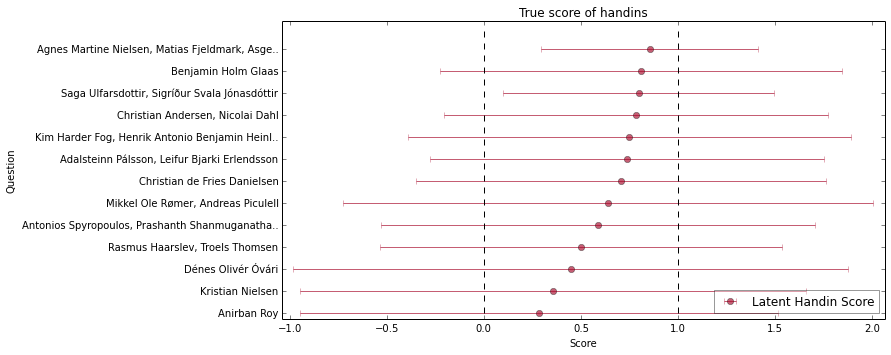

In [157]:
figsize(12.5,5)
plot_handins(a1_data,a1_result,nth=5)

In [ ]:
plot_handins_dist(a1_data,a1_result)

Average of the found score for each question in each handin

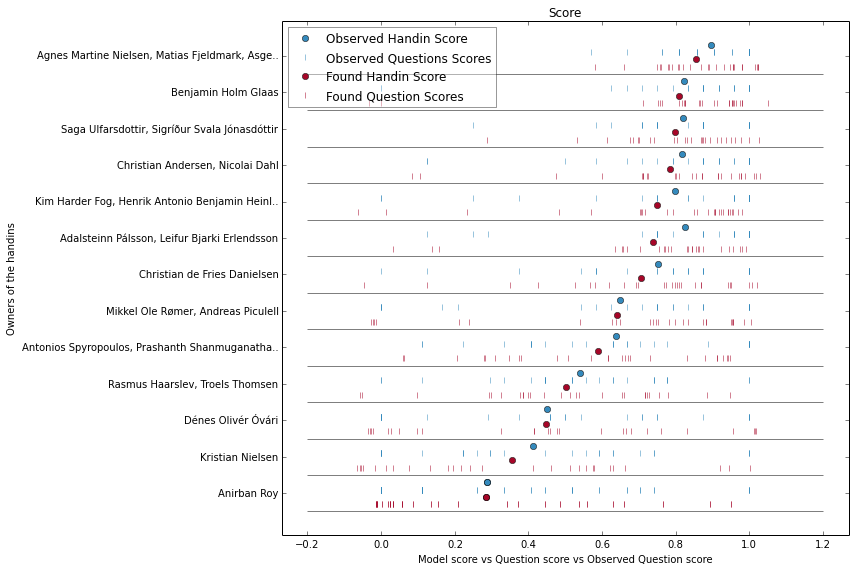

In [168]:
figsize(12,8)
plot_collected_handin_score(a1_data,a1_result,nth=5)

The observed and found gradings of each question

In [ ]:
plot_collected_question_score(a1_data,a1_result)

Bias of the graders in each question

In [ ]:
plot_question_bias(a1_data,a1_result)

The score of each questions in the handins

In [ ]:
plot_question_score(a1_data,a1_result)

In [ ]:
plot_handins_questions_scores(a1_data,a1_result)

## Assignment 2

In [45]:
a2 = data_model.Assignment.objects.get(title="Databases and Streaming")

a2_data = fetch_assignment_data(a2)

a2_result = gibbs_model(a2_data,3000,burn_in=1000)

55f69a6cb3cbf8000b5ae1c8
4000 out of 4000
Wall time: 332.548393


Expected Value: 0.025647
StD: 1.237108


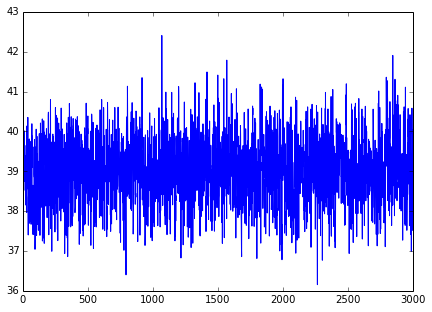

In [48]:
figsize(7,5)
print "Expected Value: %f" % (1.0 / np.mean(a2_result['n_v']))
print "StD: %f" % (1.0 / np.std(a2_result['n_v']))
plt.plot(a2_result['n_v'])
plt.show()

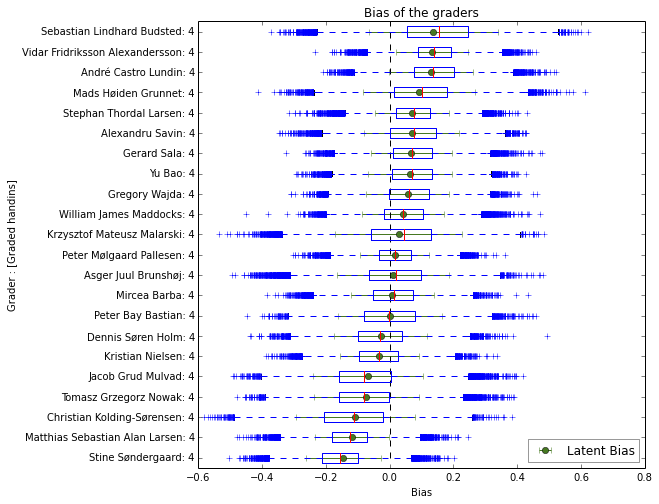

In [170]:
with PdfPages(fig_store + "CT_Ass2_Bias.pdf") as pdf:
    fig = plt.figure(figsize(8,8))
    plot_bias(a2_data,a2_result,nth=5)
    pdf.savefig(fig)

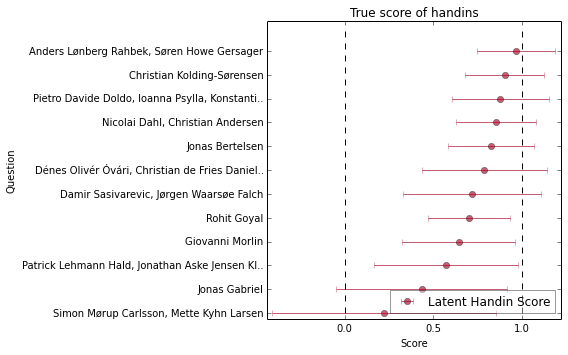

In [171]:
with PdfPages(fig_store + "CT_Ass2_Handins-pdf") as pdf:
    fig = plt.figure(figsize(8,5))
    plot_handins(a2_data,a2_result,nth=5)
    pdf.savefig(fig)

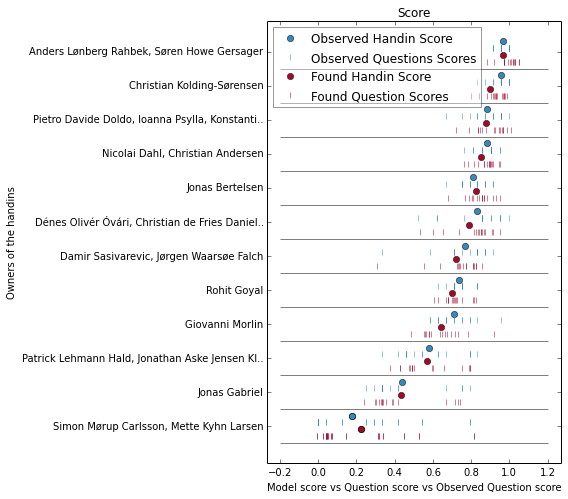

In [172]:
with PdfPages(fig_store + "CT_Ass2_Handins_Questions.pdf") as pdf:
    fig = plt.figure(figsize(8,7))
    plot_collected_handin_score(a2_data,a2_result,nth=5)
    pdf.savefig(fig)

In [ ]:
plot_collected_handin_score(a2_data,a2_result)

In [ ]:
plot_collected_question_score(a2_data,a2_result)

In [ ]:
plot_question_bias(a2_data,a2_result)

In [ ]:
plot_question_score(a2_data,a2_result)

## Assignment 3

In [46]:
a3 = data_model.Assignment.objects.get(title="Big Data and Deep Learning")

a3_data = fetch_assignment_data(a3)

a3_result = gibbs_model(a3_data,3000,burn_in=1000)

55f7cd326e34ab000b4bc376
4000 out of 4000
Wall time: 453.699742


Expected Value: 0.023981
StD: 0.643731


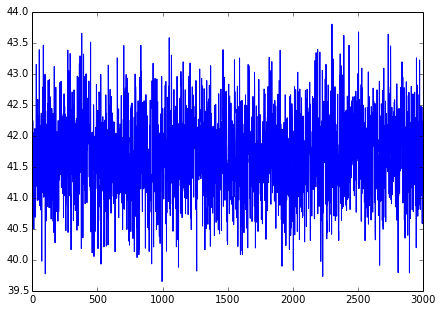

In [51]:
figsize(7,5)
print "Expected Value: %f" % (1.0 / np.mean(a3_result['n_v']))
print "StD: %f" % np.std(a3_result['n_v'])
plt.plot(a3_result['n_v'])
plt.show()

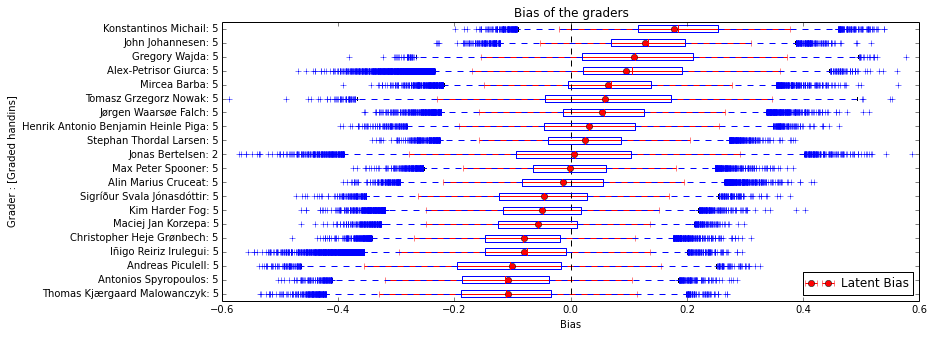

In [52]:
figsize(12.5,5)
plot_bias(a3_data,a3_result,nth=5)

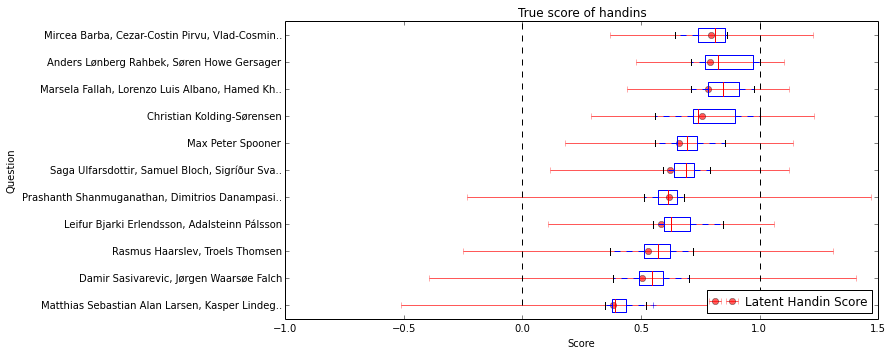

In [53]:
figsize(12.5,5)
plot_handins(a3_data,a3_result,nth=5)

In [ ]:
plot_collected_handin_score(a3_data,a3_result)

In [ ]:
plot_collected_question_score(a3_data,a3_result)

In [ ]:
plot_question_bias(a3_data,a3_result)

In [ ]:
plot_question_score(a3_data,a3_result)

## Assignment 4

In [47]:
a4 = data_model.Assignment.objects.get(title="Your Choice of Subject")

a4_data = fetch_assignment_data(a4)

a4_result = gibbs_model(a4_data,3000,burn_in=1000)

55f7cd456e34ab000b4bc37c
4000 out of 4000
Wall time: 152.724421


Expected Value: 0.023838
StD: 1.218779


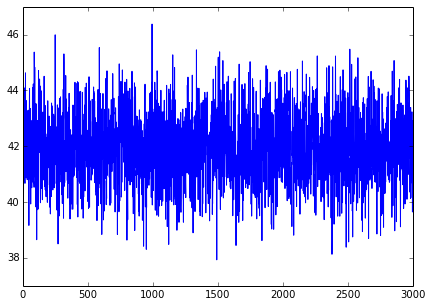

In [54]:
figsize(7,5)
print "Expected Value: %f" % (1.0 / np.mean(a4_result['n_v']))
print "StD: %f" % np.std(a4_result['n_v'])
plt.plot(a4_result['n_v'])
plt.show()

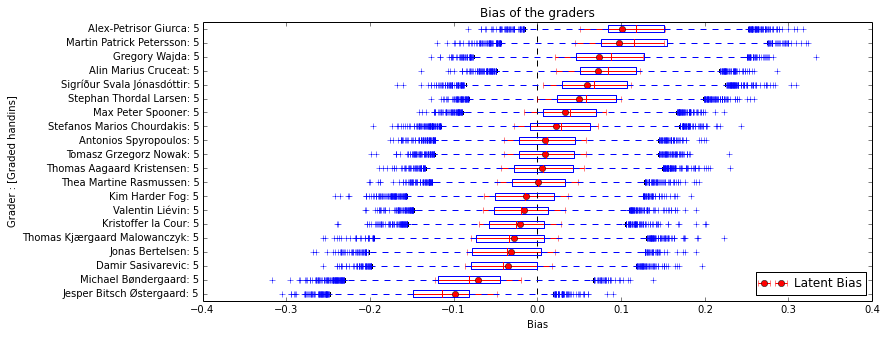

In [57]:
figsize(12,5)
plot_bias(a4_data,a4_result,nth=5)

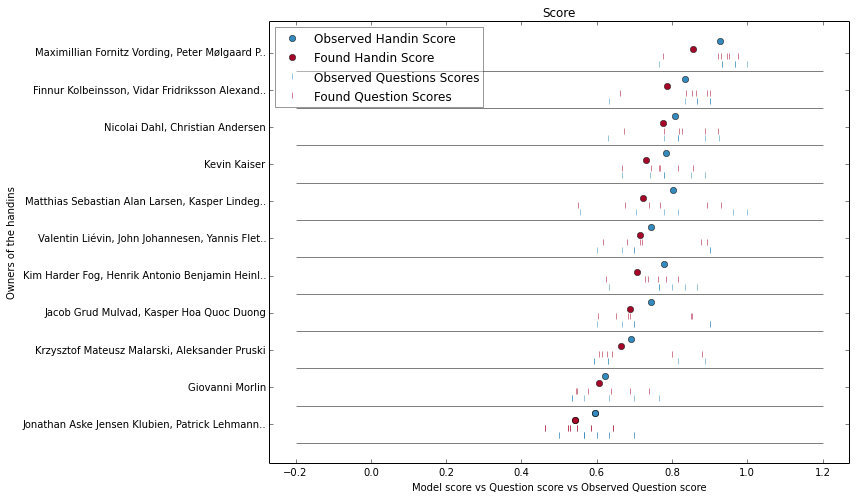

In [119]:
figsize(12,7)
plot_collected_handin_score(a4_data,a4_result,nth=5)

In [ ]:
plot_collected_handin_score(a4_data,a4_result)

In [ ]:
plot_collected_question_score(a4_data,a4_result)

In [ ]:
plot_question_bias(a4_data,a4_result)

In [ ]:
plot_question_score(a4_data,a4_result)

## Additional analysis and plots

We have only seen the bias of the graders for each assignment. So a plot of the average bias of the entire course could be useful

In [178]:
def plot_all_grader_bias(data_result,nth=1):
    
    grader_bias = defaultdict(list)
    grader_n_h = defaultdict(list)
    grader_ass = defaultdict(list)
    
    for i, (data,result) in enumerate(data_result):

        for id, g in data.graders.iteritems():
            n_h = len(data.graders[id].handins)
            grader_n_h[id].append(n_h)
            grader_bias[id].append((np.mean(result['u_g'][id])))
            grader_ass[id].append(i+1)

    scores = list()
    for name, values in grader_bias.iteritems():
        l = user_name(ObjectId(name)) + ": %i, %i" % (len(grader_n_h[name]),sum(grader_n_h[name]))
        scores.append((l,values,grader_ass[name]))
    scores.sort(key=lambda x: np.mean(x[1]))
    scores = scores[6::nth]
    
    ax = plt.subplot(111)
    
    plotted = dict()
    p_style = {1:'v',2:'.',3:'<',4:'d',5:'8',6:'s',7:'x',8:'*',9:'+'}
    
    model = map(lambda x : x[1],scores)
    model_m = map(lambda x : np.mean(x[1]),scores)
    ass = map(lambda x : x[2],scores)
    label = map(lambda x : x[0],scores)
    y = xrange(0,len(scores))
    for i, m in enumerate(model):
        for j, n in enumerate(m):
            a = ass[i][j] 
            if a not in plotted:
                plt.plot(m[j],y[i],p_style[a],color="#467821",label="Assignemnt "+str(a),alpha=0.65)
                plotted[a] = True
            else:
                plt.plot(m[j],y[i],p_style[a],color="#467821",alpha=0.65)
#    plt.boxplot(model_1,positions=y, vert=False)
    plt.plot(model_m,y,'o',color="#A60628",label="Average Bias",alpha=0.65)

    plt.yticks(xrange(0,len(scores)),label)
    leg = plt.legend(loc=4,numpoints=1)
    leg.get_frame().set_alpha(0.4)
    plt.title("Assignments Bias")
    plt.vlines(0, 0, len(scores), color="k", linestyles="--", lw=1)
    plt.ylabel("Grader: [Graded assignments], [Graded handins]")
    plt.xlabel("Bias")
    plt.margins(0.01)
    plt.show()

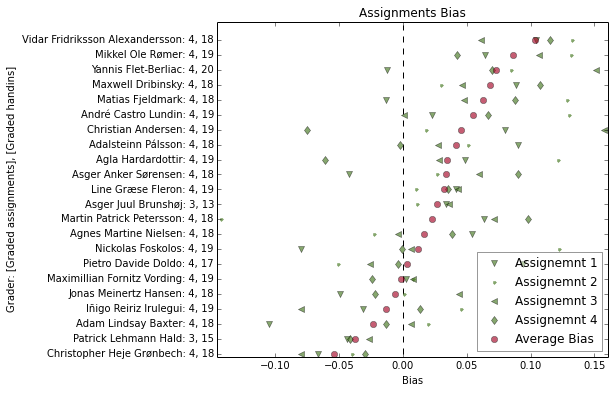

In [180]:
with PdfPages(fig_store + "CT_Ass_Bias.pdf") as pdf:
    fig = plt.figure(figsize(7,6))
    plot_all_grader_bias([(a1_data,a1_result),(a2_data,a2_result),(a3_data,a3_result),(a4_data,a4_result)],nth=5)
    pdf.savefig(fig)

Looking at this plot we can see that we have 2 graders that have extrem values. One having a very negative bias and the other having a very positiv bias.

So next we can take a closer look at induvdiual graders and compare it with previous MCMC attempt but without the question dimension to see if the same result is obtained

In [ ]:
def print_bias(ass_data,name_):
    sum_c = 0.0
    for i, (data,result) in enumerate(ass_data):
        print "Assignment %i :" % (i+1),
        sr = get_sorted_result(data,result)

        for name, value in sr:
            if name_ in name:
                print value
                sum_c = sum_c + value
    print "Mean: %f" % (sum_c / 4.0)

In [ ]:
def print_handin(ass_data,name_):
    for i, (data,result) in enumerate(ass_data):
        print "Assignment %i: " % (i+1),
        u_id = user_id(name_)
        scores = list()

        for h, handin in data.handins.iteritems():

            model_handin = data_model.Handin.objects.get(id=ObjectId(h))

            for student in model_handin.students:
                if student.id == u_id:
                    print np.mean(result['u_h'][h])
                    break
            else:
                continue  # executed if the loop ended normally (no break)
            break         


In [ ]:
def plot_question_hist((ass_data,ass_result),name_,plot = True,question = None, question_contains = None):
    '''
    Plots the questions value and the graders values for each handin the person have graded
    '''
    u_id = user_id(name_)

    bar_width = 0.2
    
    tot_neg = 0
    tot_pos = 0
    tot_net = 0
    tot_n = 0
    
    if question:
        print "Question: %s" % question_text(question)
    
    # Find the handins that the person have graded    
    for handin in ass_data.graders[str(u_id)].handins:
        # find the values of each question in each hadnin
        print "Handin: %s" % handin.id
        
        neutral = 0
        positive = 0
        negative = 0
        
        n_q = 0
        
        for q in ass_data.questions.iterkeys():
            if question and q <> question:
                continue
            if question_contains:
                if question_contains not in question_text(q):
                    continue
                else:
                    print question_text(q)
                    
            tot_n = tot_n + 1 
            n_q = n_q + 1 
            
            q_data_model = data_model.Question.objects.get(id=ObjectId(q))
            q_max = question_max_value(q_data_model)            
            
            q_values = map(lambda x : int(x*q_max),handin.answers[q].values())
            g_q_val = int(handin.answers[q][str(u_id)]*q_max)

            val = [0]*(q_max+1)
            for q_val in q_values:
                val[q_val] = val[q_val] + 1
                
            if np.median(q_values) - 0.5 > g_q_val:
                tot_neg = tot_neg + 1
                negative = negative + 1
                if plot:
                    print "[Negative]",
            elif np.median(q_values) + 0.5 < g_q_val:
                tot_pos = tot_pos + 1
                positive = positive + 1
                if plot:
                    print "[Positive]",
            else:
                tot_net = tot_net + 1
                neutral = neutral + 1
                if plot:
                    print "[Neutral]",

                    
            if plot:
                print "Median: %f" % np.median(q_values),
                print "Given score: %i" % g_q_val

                ax = plt.subplot(111) 

                bar = plt.bar(range(0,q_max+1),val,width=bar_width,alpha = 0.65, linewidth=0,align='center',color='gray')
                bar[g_q_val].set_color('r')
                plt.xticks(range(0,q_max+1),range(0,q_max+1))
                box = ax.get_position()
                ax.set_position([box.x0, box.y0,
                                 box.width*2, box.height*1])
                plt.legend(loc=4)
                plt.ylim(0,max(val)+1)
                plt.title(question_text(q))
                plt.xlabel("value")
                plt.show()

        result = sorted([("Positive",positive),("Neutral",neutral),("Negative",negative)],key=lambda x : x[1], reverse=True)
        for (l,v) in result:
            print str(v) + " " + l,
        if not question or not question_contains:
            print "out of %i" % n_q
        print
    
    if not question or not question_contains:
        print "Total result:"
        result = sorted([("Positive",tot_pos),("Neutral",tot_net),("Negative",tot_neg)],key=lambda x : x[1], reverse=True)
        for (l,v) in result:
            print str(v) + " " + l + " (%.1f%%)" % ((float(v)/float(tot_n))*100.0),
        print "out of %i" % tot_n
    print 

In [ ]:
collected_ass_data = [(a1_data,a1_result),(a2_data,a2_result),(a3_data,a3_result),(a4_data,a4_result)]

## Closer look at Christopher Heje Grønbech

Christopher have reecived an extrem negativ bias compare to the others so we should take a closer look at what he receives in each assignment an compare them with the result from the simple gibbs version

In [ ]:
print_bias(collected_ass_data,u'Christopher Heje Grønbech')

Data from simple gibbs version
```
Course: -0.0789761134265
Assignment 1: -0.0236161307972
Assignment 2: -0.00428330082791
Assignment 3: -0.0136591555037
Assignment 4: -0.0710126980259
Mean: -0.028143
```
Old data
```
Course: -0.0440840625957
Assignment 1: -0.0766746859288
Assignment 2: -0.0587217441611
Assignment 3: -0.0818907042282
Assignment 4: -0.0384273246846
Mean: -0.063929
```

Comparing the two we can see that the models heavily disagrees on the assignment 1 and 4

In [ ]:
print_handin(collected_ass_data,u'Christopher Heje Grønbech')

Compared with simple Gibbs
```
Assignment 1:  0.799938550192
Assignment 2:  0.8401262273
Assignment 3:  0.773714690198
Assignment 4:  0.892798337291
```

The handin scores are close to eachother but differes somewhat in assignment 3 and 4

We can take a closer look at how Christophers given scores for each question in each handins are compared in the distributed scores.

A scores nature can be found by looking at the median score given for a question and compare it with the graders own given score for that question. The score is considered neutral if it is the same as the median score given. Since median can give a number that is not on the scale such as 2.5 in a descreet range form 0 to 5. Then a score with 0.5 difference from the median score is also netural. A score that have a score lower than 0.5 from the median is negative and higher than 0.5 is positive.

This means that I don't consider how much negative or positive the score is. Only a descret value.

In [ ]:
plot_question_hist((a1_data,a1_result),u'Christopher Heje Grønbech',plot=False)

The Questions that Christopher tends to give a more negative score for is question where he have to evaluate how good the solution is

In [ ]:
plot_question_hist((a1_data,a1_result),u'Christopher Heje Grønbech',plot=True,question_contains="How good is the solution")

We can see that 38.5% of these are negative scores for assignment 1

In [ ]:
plot_question_hist((a2_data,a2_result),u'Christopher Heje Grønbech',plot=False)

In [ ]:
plot_question_hist((a3_data,a3_result),u'Christopher Heje Grønbech',plot=False)

In [ ]:
plot_question_hist((a4_data,a4_result),u'Christopher Heje Grønbech')

About 24% of the scores that Christopher gives to a question is negative and only about 8% of them are positive.

## Closer look at Adrian Anton Guerra

Adrian have received a very positiv bias

In [ ]:
print_bias(collected_ass_data,u'Adrian Anton Guerra')

The same as previously but this time it is in the positive direction


Data from simple gibbs version

```
Course: 0.0727281669324
Assignment 1: 0.017094341037
Assignment 2: 0.0775568078919
Assignment 3: -0.00120101595042
Assignment 4: 0.0651328775501
Mean: 0.039646
```
Old Data
```
Course: 0.113549530343
Assignment 1: 0.203054360648
Assignment 2: 0.150933129194
Assignment 3: 0.150058610318
Assignment 4: 0.119413250691
Mean: 0.155865
```

again wee see that the models differe widely on assignment 1 and 4

In [ ]:
print_handin(collected_ass_data,u'Adrian Anton Guerra')

Compared with simple Gibbs

```
Assignment 1:  0.449699645118
Assignment 2:  0.436267808366
Assignment 3:  0.681604338848
Assignment 4:  0.602263857121
```

The handin scores differs greatly on assignment 3 and 4

We perform the same analysis of last and plots the scores that Adrian have given compared with other graders for assignment 1 and 4

In [ ]:
plot_question_hist((a1_data,a1_result),u'Adrian Anton Guerra',plot=False)

Adrian also have some problems when evaluating if the solution is good. Here he tends to provide a positive scores.

In [ ]:
plot_question_hist((a1_data,a1_result),u'Adrian Anton Guerra',question_contains="How good is the")

Adrian is very easy to impress, 32.1% of the scores given a positive and not a single negative score given for thse types of question

In [ ]:
plot_question_hist((a2_data,a2_result),u'Adrian Anton Guerra',plot=False)

In [ ]:
plot_question_hist((a3_data,a3_result),u'Adrian Anton Guerra',plot=False)

In [ ]:
plot_question_hist((a4_data,a4_result),u'Adrian Anton Guerra')

Adrian is very positive when giving grades. Around 26% of them are positive and only in assignment 3 does he give any negative scores

For these extreme cases, the models found biases can definitely be justified by the nature of the scores the graders have given

Christopher received a very negative bias and he gave around 30% negative scores and considereable less positive scores

Adrain on the other hand received a very positive bias and gave around 35% positive scores and very, very few negative scores.

I have analysed other cases which are interresting to look at

## Closer look at Peter Mølgaard Pallesen

Peter have received an neutral bias overall, so the questions he have answered should have mostly neutral answeres or the equal amount of positive and negative answeres

In [ ]:
print_bias(collected_ass_data,u'Peter Mølgaard Pallesen')

Bias from simple Gibbs

```
Course: 0.0782145069958
Assignment 1: -0.0297432651489
Assignment 2: 0.0207984158203
Assignment 3: -0.00777320365113
Assignment 4: 0.0722624901704
Mean: 0.013886
```

The two models disagrees most on assignment 2 and 3 and the men bias are not simila

In [ ]:
print_handin(collected_ass_data,u'Peter Mølgaard Pallesen')

Compared with simple Gibbs

```
Assignment 1:  0.799938550192
Assignment 2:  0.8401262273
Assignment 3:  0.773714690198
Assignment 4:  0.892798337291
```

The model agrees on 1 and 2 but slightly disagrees on 3 and 4

In [ ]:
plot_question_hist((a1_data,a1_result),u'Peter Mølgaard Pallesen',plot=False)

In [ ]:
plot_question_hist((a2_data,a2_result),u'Peter Mølgaard Pallesen',plot=False)

In [ ]:
plot_question_hist((a3_data,a3_result),u'Peter Mølgaard Pallesen',plot=False)

In [ ]:
plot_question_hist((a4_data,a4_result),u'Peter Mølgaard Pallesen',plot=False)

Peter are generally 

## Closer look at myself, Thomas Kjærgaard Malowanczyk

I have received a very negative bias aswell so taking a closer look at was interesting

In [ ]:
print_bias(collected_ass_data,u'Thomas Kjærgaard Malowanczyk')

Data from simple gibbs

```
Course: -0.0155012796217
Assignment 1: -0.0499590380997
Assignment 2: -0.0141316439247
Assignment 3: -0.0690994921892
Assignment 4: -0.0118984253693
Mean: -0.036272
```
Old Data
```
Course: -0.0368624906522
Assignment 1: -0.0892354145469
Assignment 2: -0.0483535112276
Assignment 3: -0.111345425823
Assignment 4: -0.0310063683701
Mean: -0.069985
```

Old:
Here the data does not that different compared to the others. but there are some difference in assignment 3 and 4.
The mean bias are similar

In [ ]:
print_handin(collected_ass_data,u'Thomas Kjærgaard Malowanczyk')

Compared with simple gibbs
```
Assignment 1:  0.762258330788
Assignment 2:  0.809269609188
Assignment 3:  0.729196510121
Assignment 4:  0.804193526054
```
same patterns as before

## closer look at  Jesper Bitcsh Østergaard

In the simple Gibbs, Jesper received an extreme negative bias when looking at the entire course but not for the induvidual assignments.

Here jesper receives a lesser negative bias

In [ ]:
print_bias(collected_ass_data,u'Jesper Bitsch Østergaard')

Data from simple Gibbs

```
Course: -0.0789761134265
Assignment 1: -0.0236161307972
Assignment 2: -0.00428330082791
Assignment 3: -0.0136591555037
Assignment 4: -0.0710126980259
Mean: -0.028143
```
Old Data
```
Course: -0.151254644612
Assignment 1: -0.0418719493713
Assignment 2: -0.0411227338533
Assignment 3: -0.00683644565457
Assignment 4: -0.145515832287
Mean: -0.058837
```

Assignment 2 and 3 are bit different between the two models but  the mean bias is almost equal

In [ ]:
print_handin(collected_ass_data,u'Jesper Bitsch Østergaard')

Compared with simple Gibbs
```
Assignment 1:  0.793473246117
Assignment 2:  0.929190474768
Assignment 3:  0.759226970015
Assignment 4:  0.776836011117
```

## Closer look at Jonas Gabriel

In the simple version of Gibbs. Jonas bias differes greatly between taking the entire course as on assignment or if the methods is used on each assignment. For the entire course he received a neutral bias while for each assignment he received a very positive bias

With this Gibbs method he receied a bias that is still positive but not as extreme as the other gibbs method

In [ ]:
print_bias(collected_ass_data,u'Jonas Gabriel')

Data from simple Gibbs

```
Course: 0.00842612940583
Assignment 1: 0.0674363303694
Assignment 2: 0.133248974116
Assignment 3: 0.0333695106971
Assignment 4: 0.00804887030474
Mean: 0.060526

```
Old Data
```
Course: -0.001544046498
Assignment 1: 0.105043302249
Assignment 2: 0.270817184889
Assignment 3: 0.0591497037183
Assignment 4: 0.00422192345371
Mean: 0.109808
```

The simple and this gibbs model does not differe that much and results in almost the same bias in general.

In [ ]:
print_handin(collected_ass_data,u'Jonas Gabriel')

Compared with simple Gibbs:
```
Assignment 1:  0.449699645118
Assignment 2:  0.436267808366
Assignment 3:  0.681604338848
Assignment 4:  0.602263857121
```

## Closer look at André Castro Lundin

In the simple gibbs I saw that André received very positive biased both for the entire course and for each assignment.

Here he received a lesser positiver bias.

In [ ]:
print_bias(collected_ass_data,u'André Castro Lundin')

Data from simple Gibbs

```
Course: 0.0727281669324
Assignment 1: 0.017094341037
Assignment 2: 0.0775568078919
Assignment 3: -0.00120101595042
Assignment 4: 0.0651328775501
Mean: 0.039646
```
Old Data
```
Course: 0.105845656625
Assignment 1: 0.00859951301103
Assignment 2: 0.127293313799
Assignment 3: 0.00107292322333
Assignment 4: 0.111747439796
Mean: 0.062178
```

Here the models disagrees on assignment 1 and 2 and somewhat on assignment 4

In [ ]:
print_handin(collected_ass_data,u'André Castro Lundin')

Compare with simple Gibbs:
```
Assignment 1:  0.793473246117
Assignment 2:  0.929190474768
Assignment 3:  0.759226970015
Assignment 4:  0.776836011117
```

### Summation

The two models does not agree on the found bias of the graders for each assignment.
As we saw with the simple model. The result are different if the course is seen as one assignment or as seperate handins. The same is also true when assignments are seen as one question or a series of question.

The higher abstraction the more is generalized and additional complexity is added. Each assignment is composed differently and contains different amount of question. The difficulty of the assignment may also be different. The same can be said of question as the quality of the questions are different. Some question are binary and others are a scale. Generalizing these would impose some errors in the models.

So a higher granuality provides with a more precise result and the current model is the most optimal solution but it does impose a higher computation time.

# Bias and handin score correlation

After looking at some of the graders bias and handin scores a question appeard of wether there is a correlation between a graders bias and the score of the graders handin. 

Both myself, Christopher and Jesper have received a high score on the assignment we have handed in but we have also received a negative bias.

So the idea being that graders used their own handin as point of reference when grading others. A grader who have made a good handin would be more critical when grading others and a grader who have made a bad handin would grade mor positivly.

I do thin that this idea is a part of the bias, but I do not expect to find a correlation as bias should be a multivariable with different parameters.

In [ ]:
def handin_bias_corr(t,result):
    figsize(7,5)
    scores = list()

    for h, handin in t.handins.iteritems():

        # find the score of the handin
        model_v = np.mean(result['u_h'][h])
        # find the student who have handed in the handin
        model_handin = data_model.Handin.objects.get(id=ObjectId(h))

        for student in model_handin.students:
            if str(student.id) in result['u_g'].keys() and len( result['u_g'][str(student.id)]) != 0:
                scores.append((h,student.name,model_v,np.mean(result['u_g'][str(student.id)])))

        # plot a scatter plot with handin score on y axis and bias on x-axis
        
    scores.sort(key=lambda x:x[0])
    
    ax = plt.subplot(111)

    handin_score = map(lambda x : float(x[2]),scores)
    bias = map(lambda x : x[3],scores)
    label = map(lambda x : x[0] + x[1],scores)
    plt.plot(bias,handin_score,'or',label="Score vs bias",alpha=0.65)

    leg = plt.legend(numpoints=1,loc=1)
    leg.get_frame().set_alpha(0.4)

    plt.title("Correlation between the grader bias and the score of the graders handins")
    plt.ylabel("Score of graders handin")
    plt.xlabel("Graders Bias")
    plt.show()
    return bias, handin_score

### Assignment 1

In [ ]:
x,y = handin_bias_corr(a1_data,a1_result)
pearsonr(x,y)

### Assignment 2

In [ ]:
x,y = handin_bias_corr(a2_data,a2_result)
pearsonr(x,y)

### Assignment 3

In [ ]:
x,y = handin_bias_corr(a3_data,a3_result)
pearsonr(x,y)

### Assignment 4

In [ ]:
x,y = handin_bias_corr(a4_data,a4_result)
pearsonr(x,y)

From these plot we can see that there are no corrolation and no significatn p-values besides for assignment 2. That could be a coinsidence. But in general the hypothesis is does not hold.

There might be some noice as some student have handed in together. The quality in the group of graders may different and a good grader may have assisted a bad grader in getting a higher score.
We can try to eliminate handins that have been handed in by a group of graders and see if we come to the same conclusion

In [ ]:
def handin_bias_singel_grader_corr(t,result):
    figsize(7,5)
    scores = list()

    for h, handin in t.handins.iteritems():

        # find the score of the handin
        model_v = np.mean(result['u_h'][h])
        # find the student who have handed in the handin
        model_handin = data_model.Handin.objects.get(id=ObjectId(h))
        if len(model_handin.students) == 1:
            for student in model_handin.students:
                if str(student.id) in result['u_g'].keys() and len( result['u_g'][str(student.id)]) != 0:
                    scores.append((h,student.name,model_v,np.mean(result['u_g'][str(student.id)])))
        
    scores.sort(key=lambda x:x[0])
    
    ax = plt.subplot(111)


    handin_score = map(lambda x : float(x[2]),scores)
    bias = map(lambda x : float(x[3]),scores)
    label = map(lambda x : x[0] + x[1],scores)
    plt.plot(bias,handin_score,'or',label="Score vs bias",alpha=0.65)

    leg = plt.legend(numpoints=1,loc=1)
    leg.get_frame().set_alpha(0.4)
    plt.title("Correlation between the grader bias and the score of the graders handins")
    plt.ylabel("Score of graders handin")
    plt.xlabel("Graders Bias")
    plt.show()
    return bias, handin_score

In [ ]:
x,y = handin_bias_singel_grader_corr(a1_data,a1_result)
pearsonr(x,y)

In [ ]:
x,y = handin_bias_singel_grader_corr(a2_data,a2_result)
pearsonr(x,y)

In [ ]:
x,y = handin_bias_singel_grader_corr(a3_data,a3_result)
pearsonr(x,y)

In [ ]:
x,y = handin_bias_singel_grader_corr(a4_data,a4_result)
pearsonr(x,y)

For assignment 2 there definitely seems to be a correlation that supports the hypothesis. Assignment 3 does also have a small correlation but the p-value is not that high again. The main problem is that the amount of data has been decreased so much that making any definite answer is not possible. Further investigation may reveal that this is true for some courses or assignments

## Correlation between bias and graded hanind score

As an extension of the previous question, an additional question appeard. Is there a corralation between the graders bias and score of the handins that the grader have graded?

Again i do not hope to find a correlation as it simply means that the found bias simply says that a grader have either graded bad or good handins.

We can do the same as before but plot the graders bias agains the average of the graded handins scores

In [ ]:
def bias_handin_corr(t,result):
    figsize(7,5)
    t.graders

    scores = list()
    
    for id, g in t.graders.iteritems():
        handins_scores = list()
        for h in g.handins:
            handins_scores.append(np.mean(result['u_h'][h.id]))
        if len(handins_scores) > 0:
            scores.append((user_name(id),np.mean(handins_scores),np.mean(result['u_g'][id])))

    scores.sort(key=lambda x:x[1])
    
    ax = plt.subplot(111)

    handin_score = map(lambda x : float(x[1]),scores)
    bias = map(lambda x : float(x[2]),scores)
    label = map(lambda x : x[0],scores)
    plt.plot(bias,handin_score,'or',label="Score vs bias",alpha=0.65)

    leg = plt.legend(numpoints=1,loc=1)
    leg.get_frame().set_alpha(0.4)
    plt.title("Correlation between graders bias and graded handin scores")
    plt.ylabel("Average graded handin score")
    plt.xlabel("Grader bias")
    plt.show()
    return bias, handin_score

### Assignment 1

In [ ]:
x,y = bias_handin_corr(a1_data,a1_result)
pearsonr(x,y)

### Assignment 2

In [ ]:
x,y = bias_handin_corr(a2_data,a2_result)
pearsonr(x,y)

### Assignment 3

In [ ]:
x,y = bias_handin_corr(a3_data,a3_result)
pearsonr(x,y)

### Assignment 4

In [ ]:
x,y = bias_handin_corr(a4_data,a4_result)
pearsonr(x,y)

We see no correlation what so ever and the p-values establish the null-hypothesis that the two sets are not correlated as we find no significant p-values

### Summation

The first question might have some to it but for the second question we saw no evidence that supportet it.